In [29]:
import pandas as pd
# R에서 구분한 RFM 데이터프레임 csv로 가져옴
s_RFM = pd.read_csv('s_RFM.csv')

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager, rc
%matplotlib inline
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [8]:
shopping = pd.read_csv('new_shopping.csv',  encoding = 'euc-kr')

In [21]:
shopping_id = shopping.drop_duplicates(subset=['ID'], keep='first')

In [26]:
shopping_id = shopping_id[['ID', '연령대']]

In [53]:
# 인덕스를 ID로 변경
shopping_id = shopping_id.set_index('ID')

In [30]:
# 날짜를 datetime 형태로 바꿔줌
import datetime

for day in s_RFM['Recency']:
    convert_date = datetime.datetime.strptime(str(day), "%Y%m%d").date()
    s_RFM['Recency'].replace({day:convert_date}, inplace=True)

In [31]:
# 필요없는 컬럼 삭제
s_RFM = s_RFM.drop(columns='Unnamed: 0')

In [32]:
s_RFM.head()

,ID,Recency,Frequency,Monetary
0,1,2015-12-28,43,3695930
1,2,2015-12-20,55,1979142
2,3,2015-12-24,32,2272884
3,4,2015-12-28,122,7970116
4,6,2015-12-27,280,6458914


# RFM 분석
### 출처 - https://github.com/joaolcorreia/RFM-analysis/blob/master/RFM%20Analysis.ipynb
#### RFM class -> 1이 높음, 4가 낮음

In [33]:
# Since recency is calculated for a point in time and the Tableau Super Store dataset last order date is Dec 31 2015, that is the date we will use to calculate recency.
import datetime as dt
NOW = dt.datetime(2015,12,31)

In [34]:
# Make the date_placed column datetime
s_RFM['Recency'] = pd.to_datetime(s_RFM['Recency'])

In [35]:
# 점수화한 Recency 생성
R = s_RFM.groupby('ID').agg({'Recency': lambda x: (NOW - x.max()).days})

In [36]:
# 원래 rfm df와 Recency 점수화한 df 결합
RFM_df = pd.merge(s_RFM, R, left_on = 'ID', right_index=True)

In [37]:
RFM_df.head()

,ID,Recency_x,Frequency,Monetary,Recency_y
0,1,2015-12-28,43,3695930,3
1,2,2015-12-20,55,1979142,11
2,3,2015-12-24,32,2272884,7
3,4,2015-12-28,122,7970116,3
4,6,2015-12-27,280,6458914,4


In [38]:
# 기존 날짜 컬럼 삭제
RFM_df = RFM_df.drop(columns = 'Recency_x')

In [39]:
# 인덕스를 ID로 변경
RFM_df = RFM_df.set_index('ID')

In [40]:
# Recency 컬럼명 변경
RFM_df = RFM_df.rename(columns = {'Recency_y':'Recency'})

In [41]:
# determining RFM Quartiles
quantiles = RFM_df.quantile(q=[0.25,0.5,0.75])

In [42]:
quantiles

,Frequency,Monetary,Recency
0.25,11.0,486975.0,4.0
0.50,35.0,1846536.0,11.0
0.75,82.0,4875377.5,42.0


In [43]:
quantiles = quantiles.to_dict()

In [44]:
quantiles

{'Frequency': {0.25: 11.0, 0.5: 35.0, 0.75: 82.0},
 'Monetary': {0.25: 486975.0, 0.5: 1846536.0, 0.75: 4875377.5},
 'Recency': {0.25: 4.0, 0.5: 11.0, 0.75: 42.0}}

In [45]:
rfmSegmentation = RFM_df

In [46]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [47]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['Recency'].apply(RClass, args=('Recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['Frequency'].apply(FMClass, args=('Frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['Monetary'].apply(FMClass, args=('Monetary',quantiles,))

In [48]:
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)

In [49]:
rfmSegmentation.to_csv("FRM_segmentation2.csv")

In [50]:
# 20개만 예시로
rfmSegmentation.head(20)

,Frequency,Monetary,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass
ID,,,,,,,
1,43,3695930,3,1,2,2,122
2,55,1979142,11,2,2,2,222
3,32,2272884,7,2,3,2,232
4,122,7970116,3,1,1,1,111
6,280,6458914,4,1,1,1,111
7,50,2650880,16,3,2,2,322
8,59,7635203,27,3,2,1,321
9,72,11241966,8,2,2,1,221
10,11,351800,9,2,4,4,244


In [57]:
rfm_age = pd.concat([rfmSegmentation, shopping_id], axis = 1)

Text(0.5,1,'Best')

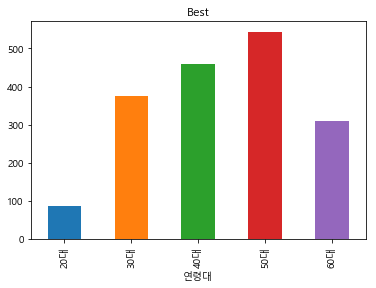

In [122]:
# 1. rfm다높은 우량고객
rfm_age[rfm_age['RFMClass']=='111'].groupby(by='연령대').count()['RFMClass'].plot(kind='bar')
plt.title('Best')

In [117]:
# 40대 두명밖에 없음
rfm_age[rfm_age['RFMClass']=='114']

,Frequency,Monetary,Recency,R_Quartile,F_Quartile,M_Quartile,RFMClass,연령대
ID,,,,,,,,
5180,106,449000,3,1,1,4,114,40대
16193,94,272080,2,1,1,4,114,40대


Text(0.5,1,'Shopper')

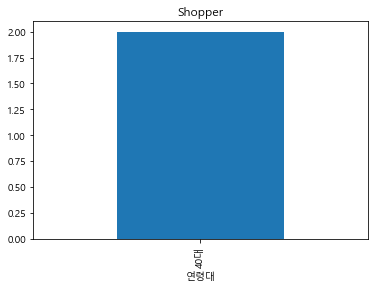

In [121]:
# 2. 가성비추구하는 shopper
rfm_age[rfm_age['RFMClass']=='114'].groupby(by='연령대').count()['RFMClass'].plot(kind='bar')
plt.title('Shopper')

Text(0.5,1,'First Time')

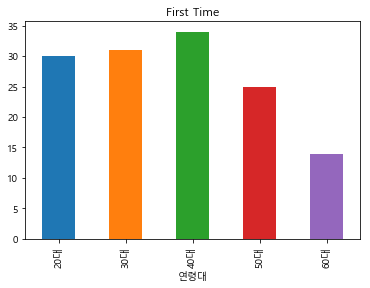

In [123]:
# 3. r만높은 첫방문 고객
rfm_age[rfm_age['RFMClass']=='144'].groupby(by='연령대').count()['RFMClass'].plot(kind='bar')
plt.title('First Time')

Text(0.5,1,'Churn')

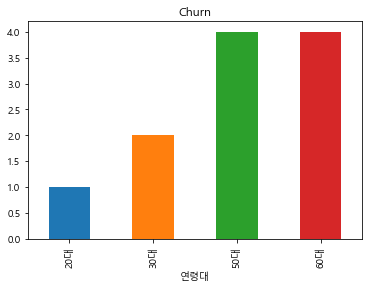

In [124]:
# 3. 중요한 고객인데 이탈한고객 Churn
rfm_age[rfm_age['RFMClass']=='411'].groupby(by='연령대').count()['RFMClass'].plot(kind='bar')
plt.title('Churn')

Text(0.5,1,'Spender')

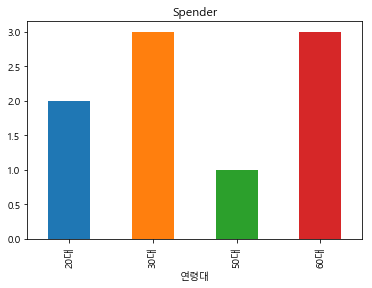

In [125]:
# 5. 한방에 많이쓰는 Spenders
rfm_age[rfm_age['RFMClass']=='441'].groupby(by='연령대').count()['RFMClass'].plot(kind='bar')
plt.title('Spender')